In [1]:
%pylab inline
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Get data 
import pandas as pd

def get_names():
  names = pd.read_csv('signnames.csv')
  for i in names['ClassId']:
    yield i

folder = []
for i in glob.glob('data_train/*'):
  folder.append(i)
  
folder.sort()

images = []
labels = []
gen = get_names()
for i in folder:
  aux = next(gen)
  for j in glob.glob((i+'/*.ppm')):
    images.append(j)
    labels.append(aux)

In [3]:
image_list = []
for i in images:
  image_list.append(imread(i))

In [4]:
from PIL import Image

In [5]:
# Simple function to resize an image to (33, 33)
resize_img = lambda x: np.array(Image.fromarray(x).resize((33, 33)))

In [6]:
from sklearn.model_selection import train_test_split
rawX = np.array([resize_img(i) for i in image_list]).astype('float')
rawY = np.array(labels)

X_train, X_test, Y_train, Y_test = train_test_split(rawX, rawY, random_state=42)

In [7]:
# Neural Network
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange

In [8]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.l1 = nn.Linear(3267, 1280, bias=False)
    self.l2 = nn.Linear(1280, 43, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x

loss 0.66 accuracy 0.81: 100%|██████████| 1000/1000 [04:10<00:00,  3.99it/s]

Loss:  0.6637769341468811
Accuracy:  0.807812511920929


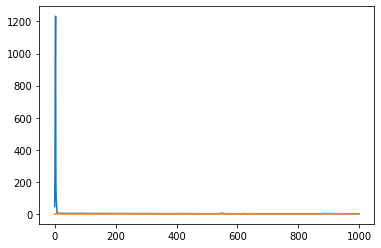

In [12]:
model = Net()

loss_function = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.0)
losses, accuracies = [], []
BS = 1280
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=BS)
  X = torch.tensor(X_train[samp].reshape((-1, 33*33*3))).float()
  Y = torch.tensor(Y_train[samp]).long()
  model.zero_grad()
  
  # forward (contains activation function inside)
  out = model(X)
  
  # loss function
  loss = loss_function(out, Y)
  loss = loss.mean()
  
  # Bacward and optimizer
  loss.backward()
  optim.step()
  
  # Stats
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  accuracy = accuracy.item()
  loss = loss.item()
  accuracies.append(accuracy)
  losses.append(loss)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))

print("Loss: ",loss)
print("Accuracy: ", accuracy)

plot(losses)
plot(accuracies)

In [13]:
# Eval
Y_pred = torch.argmax(model(torch.tensor(X_test.reshape((-1, 33*33*3))).float()), dim=1).numpy()
(Y_test == Y_pred).mean()

0.7710904825053555

In [24]:
# CNN
# https://navoshta.com/traffic-signs-classification/
import torch.optim as optim

In [39]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, 5)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 43)
  
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [40]:
net = Net()

loss_function = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.0)

losses, accuracies = [], []
BS = 1280
for i in (t := trange(1000)):
  samp = np.random.randint(0, X_train.shape[0], size=BS)
  X = torch.tensor(X_train[samp].T).float()
  print(X.shape)
  Y = torch.tensor(Y_train[samp]).long()
  net.zero_grad()
  
  # forward (contains activation function inside)
  out = net(X)
  
  # loss function
  loss = loss_function(out, Y)
  loss = loss.mean()
  
  # Bacward and optimizer
  loss.backward()
  optim.step()
  
  # Stats
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  accuracy = accuracy.item()
  loss = loss.item()
  accuracies.append(accuracy)
  losses.append(loss)
  t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plot(losses)
plot(accuracies)

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([3, 33, 33, 1280])


RuntimeError: Given groups=1, weight of size [6, 3, 5, 5], expected input[3, 33, 33, 1280] to have 3 channels, but got 33 channels instead